# Team HufflePuff

Andres Gonzalez, Ian Trolinger, Evan Franklin, Syed Ahmed

San Jose State University: BUS 118S (Big Data)

# Questions

1. Do reviews written on certain days of the week tend to rate businesses higher or lower than the average for that business?
2. Does this vary by top-level category?
3. Does this vary by city?


# Hypothesis & Assumptions

**1. Do reviews written on certain days of the week tend to rate businesses higher or lower than the average for that business?**
> We fully expect that the ratings will vary on certain days for particular businesses. Our group suspects that fridays, saturdays, and sundays will consist of higher reviews compared to the rest of the week due. This can be a factor of an overall better attitude and less stress due to it being the weekend, people are often in better moods when they don't have to stress about work.

**2. Does this vary by top-level category, cuisine, city, elite, etc...?**
> While we fully expect there to be a trend in higher ratings during the weekend, we also assume that this trend will distinctively vary by top-level category as well as by city.  

# References

References:

>Data Dictionary: https://www.yelp.com/dataset/documentation/json

>Download Yelp Dataset: https://www.yelp.com/dataset/download


# Introduction

With the assumptions made prior to starting this project, the next step for our group would be to choose which datasets will help us answer our questions. This being said we have chosen review.json, categories.json, and business.json. The review.json will give us every review written as well as the day of the week it was written on. Along with the review.json, we will use the business.json to calculate the average stars for each business then take the difference between each review rating and that business average. We will also use business.json to figure out which city/metropolitan area each business is located in. Finally we will use the category.json to determine the top-level categories each business can be classified under. With these three json files we will prepare and structure several dataframes that help answer our questions. We will also develop two dataframes with the purpose of converting them into CSV files that will be used to develop visualizations on tableau. Our question can be split up into three parts so we will answer each part individually. For each part we will begin with preparing and structuring the neccesary dataframes, followed by the results and visualizations, finishing up with our concluding answer. 

In the cells below, we are creating temporary views of the category, business, and review json files so that we can see what information is in each of the files. This will help us choose which files to extract from when creating our dataframes in order to answer our questions. 

In [3]:
# The code was removed by DSX for sharing.

In [4]:
path_categories = cos.url('categories.json.bz2', 'teamhufflepuffyelpproject-donotdelete-pr-i8pakxtdmhzaka')
df_categories = spark.read.json(path_categories)
df_categories.printSchema()

#Temporary View
df_categories.createOrReplaceTempView("categories")

root
 |-- alias: string (nullable = true)
 |-- country_blacklist: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- country_whitelist: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- parents: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)



In [5]:
path_business = cos.url('business.json.bz2', 'teamhufflepuffyelpproject-donotdelete-pr-i8pakxtdmhzaka')
df_business = spark.read.json(path_business)
df_business.printSchema()

#Temporary View
df_business.createOrReplaceTempView("business")

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: boolean (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: struct (nullable = true)
 |    |    |-- casual: boolean (nullable = true)
 |    |    |-- classy: boolean (nullable = true)
 |    |    |-- divey: boolean (nullable = true)
 |    |    |-- hipster: boolean (nullable = true)
 |    |    |-- intimate: boolean (nullable = true)
 |    |    |-- romantic: boolean (nullable = true)
 |    |    |-- touristy: boolean (nullable = true)
 |    |    |-- trendy: boolean (nullable = true)
 |    |    |-- upscale: boolean (nullable = true)
 |    |-- BYOB: boolean (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: struct (nullable = true)
 |    |    |-- friday: boolean (nullable = true)
 |    |    |-- monday: boolean (nullable = true)
 |    |    |-- saturday: boolean (nullab

In [9]:
path_reviews = cos.url('review.json.bz2', 'teamhufflepuffyelpproject-donotdelete-pr-i8pakxtdmhzaka')
df_reviews = spark.read.json(path_reviews)
df_reviews.printSchema()

#Temporary View
df_reviews.createOrReplaceTempView("reviews")

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



----------------------------------------------------------------------------------------
# Question 1: Do reviews written on certain days of the week tend to rate businesses higher or lower than the average for that business?

## Preparing and Structuring the Data: 

The first step we want to do is create a dataframe that shows us the average number of stars for each business. This dataframe will be named **"business_avg"**. While it is only somewhat helpful to view this alone, this dataframe will soon be joined with the next couple of dataframes we will make in order to compare a business's average stars to each review on different days of the week. 

In [10]:
business_avg = spark.sql("""
SELECT  business_id as Business,
        ROUND(AVG(stars),2) as Average_Stars
FROM reviews
GROUP BY business_id
""")

business_avg.show(10, truncate = False)

+----------------------+-------------+
|Business              |Average_Stars|
+----------------------+-------------+
|llCxryWr8j1S39tusYCWxg|4.3          |
|--9e1ONYQuAa-CB_Rrw7Tw|4.09         |
|l3V86Z6oAzpnwe1VYM4VPg|3.37         |
|5TXQxcwEfqzBDbMq2zmBPQ|3.84         |
|RMjCnixEY5i12CiqnskiVw|3.52         |
|Jjd7JhPXoarspG4Y2W3SGg|3.0          |
|t5nyOtnEv455rShOS_g3RA|4.36         |
|6iF_2AJrrzSMHnXVI79Odw|5.0          |
|gogO5RF4Rqz2THF1ATcCew|3.52         |
|o8uCIT_YDDDr9KExfSjsUw|2.76         |
+----------------------+-------------+
only showing top 10 rows



Then we want to generate a dataframe that shows us the given rating and weekday from each review, but we have to change the format of the date given in the reviews dataset (YYYY-DD-MM) to a specific weekday so we can compare each day. This dataframe will be named **"review_DOW"**. (DOW stands for Day of Week)

In [11]:
review_DOW = spark.sql("""
SELECT business_id as Business, review_id as review, stars as Rating, DATE_FORMAT(date, "EEEE") as weekday
FROM reviews

""")

review_DOW.show(10, truncate = False)

+----------------------+----------------------+------+---------+
|Business              |review                |Rating|weekday  |
+----------------------+----------------------+------+---------+
|0W4lkclzZThpx3V65bVgig|v0i_UHJMo_hPBq9bxWvW4w|5     |Saturday |
|AEx2SYEUJmTxVVB18LlCwA|vkVSCC7xljjrAI4UGfnKEQ|5     |Saturday |
|VR6GpWIda3SfvPC-lg9H3w|n6QzIUObkYshz4dz2QRJTw|5     |Saturday |
|CKC0-MOWMqoeWf6s-szl8g|MV3CcKScW05u5LVfF6ok0g|5     |Saturday |
|ACFtxLv8pGrrxMm6EgjreA|IXvOzsEMYtiJI0CARmj77Q|4     |Saturday |
|s2I_Ni76bjJNK9yG60iD-Q|L_9BTb55X0GDtThi6GlZ6w|4     |Saturday |
|8QWPlVQ6D-OExqXoaD2Z1g|HRPm3vEZ_F-33TYVT7Pebw|5     |Wednesday|
|9_CGhHMz8698M9-PkVf0CQ|ymAUG8DZfQcFTBSOiaNN4w|4     |Friday   |
|gkCorLgPyQLsptTHalL61g|8UIishPUD92hXtScSga_gw|4     |Tuesday  |
|5r6-G9C4YLbC7Ziz57l3rQ|w41ZS9shepfO3uEyhXEWuQ|3     |Saturday |
+----------------------+----------------------+------+---------+
only showing top 10 rows



Next we will create the **"test"** dataframe. In this dataframe we will inner join the **business_avg** dataframe with the **review_DOW** dataframe in order to be able to compare specific reviews with the business's overall average. We will achieve this by calculating the difference between the rating in a review and the business's average rating (Rating - Average_Stars). This difference will allows us to compare the difference on different days of the week in dataframes to follow. A "compare" column will be added to this dataframe which easily shows whether a rating is higher or lower than the business's average. When compare = 1, the rating is less than the business average. When compare = 2, the rating is higher than the business average. We also included a third option, when compare = 3, for when the rating is equal to the business average.  

In [12]:
review_DOW.createOrReplaceTempView("review_DOW")
business_avg.createOrReplaceTempView("business_avg")
test = spark.sql("""
SELECT R.*, B.Average_Stars, (R.Rating - B.Average_Stars)  AS Difference,
    CASE
        WHEN (R.Rating - B.Average_Stars) > 0 THEN 2
        WHEN (R.Rating - B.Average_Stars) < 0 THEN 1
        WHEN (R.Rating - B.Average_Stars) = 0 THEN 3
        ELSE 0
    END AS compare
FROM review_DOW AS R INNER JOIN business_avg AS B ON R.Business = B.Business 
""")

test.show(10, truncate = False)
print("when compare = 1 rating is less than the business' avg rating")
print("when compare = 2 rating is greater than the business' avg rating")
print("when compare = 3 rating is equal to the business' avg rating")

+----------------------+----------------------+------+---------+-------------+--------------------+-------+
|Business              |review                |Rating|weekday  |Average_Stars|Difference          |compare|
+----------------------+----------------------+------+---------+-------------+--------------------+-------+
|--9e1ONYQuAa-CB_Rrw7Tw|SBolW_XVnwrGbbTnoCJsKg|5     |Friday   |4.09         |0.9100000000000001  |2      |
|--9e1ONYQuAa-CB_Rrw7Tw|LutE140GVeYg9ixbbYi7Ew|5     |Monday   |4.09         |0.9100000000000001  |2      |
|--9e1ONYQuAa-CB_Rrw7Tw|1dKQm0-_v5ts8Buwns5oEw|5     |Friday   |4.09         |0.9100000000000001  |2      |
|--9e1ONYQuAa-CB_Rrw7Tw|PMUUtaAMVOD_TAiBc2u7OQ|5     |Sunday   |4.09         |0.9100000000000001  |2      |
|--9e1ONYQuAa-CB_Rrw7Tw|QtLQQlmFINUSb2K_gE7J1Q|4     |Tuesday  |4.09         |-0.08999999999999986|1      |
|--9e1ONYQuAa-CB_Rrw7Tw|SdU1NeNd1aAxIk64w9y2Ng|2     |Friday   |4.09         |-2.09               |1      |
|--9e1ONYQuAa-CB_Rrw7Tw|1kHO

After importing the **test** dataframe into tableau, the visualization above was created in order to clearly answer our question. Based off this visualizastion, it can be stated that reviews written on certain days of the week do tend to rate a business higher or lower than the average for that business. Reviews written on Friday-Sunday trend lower than the business average while reviews written on Tuesday-Thursday trend higher. 

# RESULTS:

## Dataframe Summary: Weekday Average Difference, Number of Reviews, Total Above and Below Average

While the dataframes and visualization above are helpful for answering our question, we can transform them in order to better understand and summarize what the overall trends are for all businesses on each day of the week.  This being said, the first step to achieve this is the dataframe below that shows the total number of reviews for each day of the week. This dataframe will be called **"day_count"**. Like the "business_avg" dataframe made in the beginning of this project, this dataframe is helpful to look at but its main purpose is to be joined with the next couple of dataframes that will be created. 

In [13]:
review_DOW.createOrReplaceTempView("review_DOW")

day_count = spark.sql("""
SELECT weekday, COUNT(review) as Total_Reviews
FROM review_DOW
GROUP BY weekday
ORDER BY Total_Reviews
""")

day_count.show()

+---------+-------------+
|  weekday|Total_Reviews|
+---------+-------------+
|   Friday|       709704|
| Thursday|       712783|
|  Tuesday|       747057|
| Saturday|       749883|
|Wednesday|       753938|
|   Monday|       793559|
|   Sunday|       794745|
+---------+-------------+



Similarly to the "day_count" dataframe above, we will next create an **"avg_updown"** dataframe. We previously created a diffrence column in the "test" dataframe above which showed the difference between a rating in a review and that business' average rating. In this "avg_updown" dataframe we will take the average of every difference and group them by day of the week. This will enable us to see the average difference for each day of the week. When the average difference is negative, that indicates that reviews tend to be lower than business' averages. When average difference is positive, that indicates that reviews tend to be higher than business' averages.  

In [14]:
test.createOrReplaceTempView("test")

avg_updown = spark.sql("""
SELECT weekday, ROUND(AVG(difference), 5) AS AVG_Difference
FROM test
GROUP BY weekday
""")

avg_updown.show()

+---------+--------------+
|  weekday|AVG_Difference|
+---------+--------------+
|Wednesday|       0.02315|
|  Tuesday|       0.01265|
|   Friday|       0.01616|
| Thursday|       0.02599|
| Saturday|      -0.01492|
|   Monday|      -0.01745|
|   Sunday|      -0.04058|
+---------+--------------+



While the avg_difference is helpful in answering our question, it alone is still not enough. That being said, we will next create a **"total_up_down"** dataframe which can be achieved by creating the two dataframes "total_up" and "total_down" and joining them together. The **"total_up"** dataframe collects the total number of reviews that were HIGHER than business' averages from the "test" dataframe made previously and the **"total_down"** dataframe collects the opposite. We will also include a **"total_equal"** dataframe to account for all reviews equal to the business average. These three dataframes are not neccessary to see alone so we only show the combination of them in order to avoid confusion and wasted time.  

In [15]:
test.createOrReplaceTempView("test")

total_up = spark.sql("""
SELECT weekday, COUNT(compare) AS Total_Up
FROM test
WHERE compare = 2
GROUP BY weekday
""")

total_down = spark.sql("""
SELECT weekday, COUNT(compare) AS Total_Down
FROM test
WHERE compare = 1
GROUP BY weekday
""")

total_equal = spark.sql("""
SELECT weekday, COUNT(compare) AS Total_Equal
FROM test
WHERE compare = 3
GROUP BY weekday
""")

total_up.createOrReplaceTempView("total_up")
total_down.createOrReplaceTempView("total_down")
total_equal.createOrReplaceTempView("total_equal")

total_up_down = spark.sql("""
SELECT T.weekday, T.Total_Up, D.Total_Down, E.Total_Equal
FROM total_up AS T INNER JOIN total_down AS D ON T.weekday = D.weekday INNER JOIN total_equal AS E ON T.weekday = E.weekday
""")

total_up_down.show()

+---------+--------+----------+-----------+
|  weekday|Total_Up|Total_Down|Total_Equal|
+---------+--------+----------+-----------+
|Wednesday|  439747|    285792|      28399|
|  Tuesday|  431441|    288184|      27432|
|   Friday|  414027|    268977|      26700|
| Thursday|  417159|    268032|      27592|
| Saturday|  435271|    292193|      22419|
|   Monday|  451461|    317698|      24400|
|   Sunday|  451902|    323277|      19566|
+---------+--------+----------+-----------+



In order to bring it all together now we will create the **"combo"** dataframe below. This dataframe is combining the **"day_count"**, **"avg_updown"**, and **"total_up_down"** dataframes in order to clarify whether or not reviews written on certain days of the week tend to be higher or lower than the average. The "total" column lists the total number of reviews for each day of the week. The "avg_difference" column gives the total average difference between a rating and a business' avg rating for each day of the week. The "total_up" column consists of the total number of ratings that are higher than the business' avg rating. The "total_down" is similar to the "total_up" column but consists of the total number of ratings that are lower than the business' avg rating. Finally, the "total_equal" column simply accounts for each rating that was equal to the business average.

In [16]:
day_count.createOrReplaceTempView("day_count")
avg_updown.createOrReplaceTempView("avg_updown")
total_up_down.createOrReplaceTempView("total_up_down")

combo = spark.sql("""
SELECT D.weekday, D.Total_Reviews AS Total, A.AVG_Difference, T.Total_Up, T.Total_Down, T.Total_Equal
FROM day_count AS D INNER JOIN avg_updown AS A ON D.weekday = A.weekday INNER JOIN total_up_down AS T ON D.weekday = T.weekday

""")
combo.show()


+---------+------+--------------+--------+----------+-----------+
|  weekday| Total|AVG_Difference|Total_Up|Total_Down|Total_Equal|
+---------+------+--------------+--------+----------+-----------+
|Wednesday|753938|       0.02315|  439747|    285792|      28399|
|  Tuesday|747057|       0.01265|  431441|    288184|      27432|
|   Friday|709704|       0.01616|  414027|    268977|      26700|
| Thursday|712783|       0.02599|  417159|    268032|      27592|
| Saturday|749883|      -0.01492|  435271|    292193|      22419|
|   Monday|793559|      -0.01745|  451461|    317698|      24400|
|   Sunday|794745|      -0.04058|  451902|    323277|      19566|
+---------+------+--------------+--------+----------+-----------+



# RESULTS (continued):

## Tableau Visualizations Summary:

Below is a visualization created from the **combo** dataframe. This box and whiskers graph is showing the variance in the average difference of all businesses for each day of the week.  

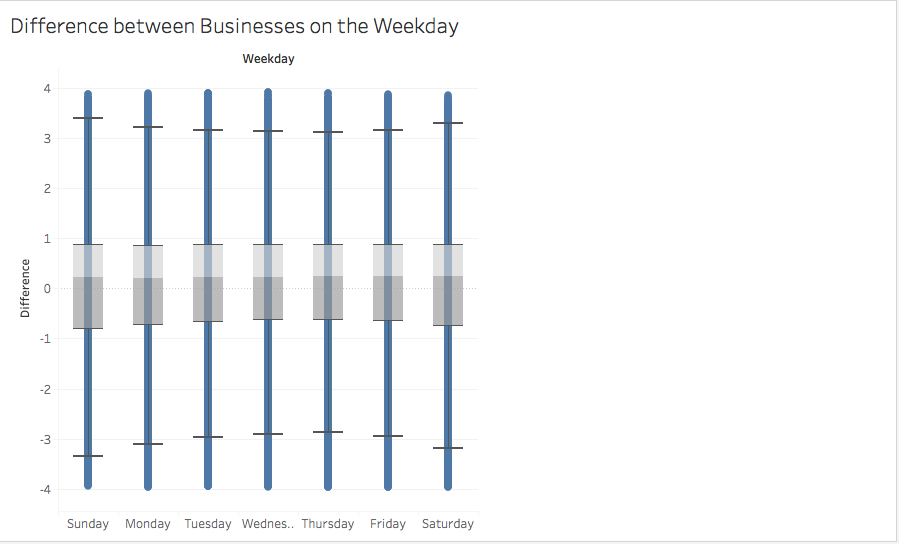

Below is a visualization also created from the **combo** dataframe. This bar chart is showing the total number of reviews that are above, below, and equal to a business' average.  

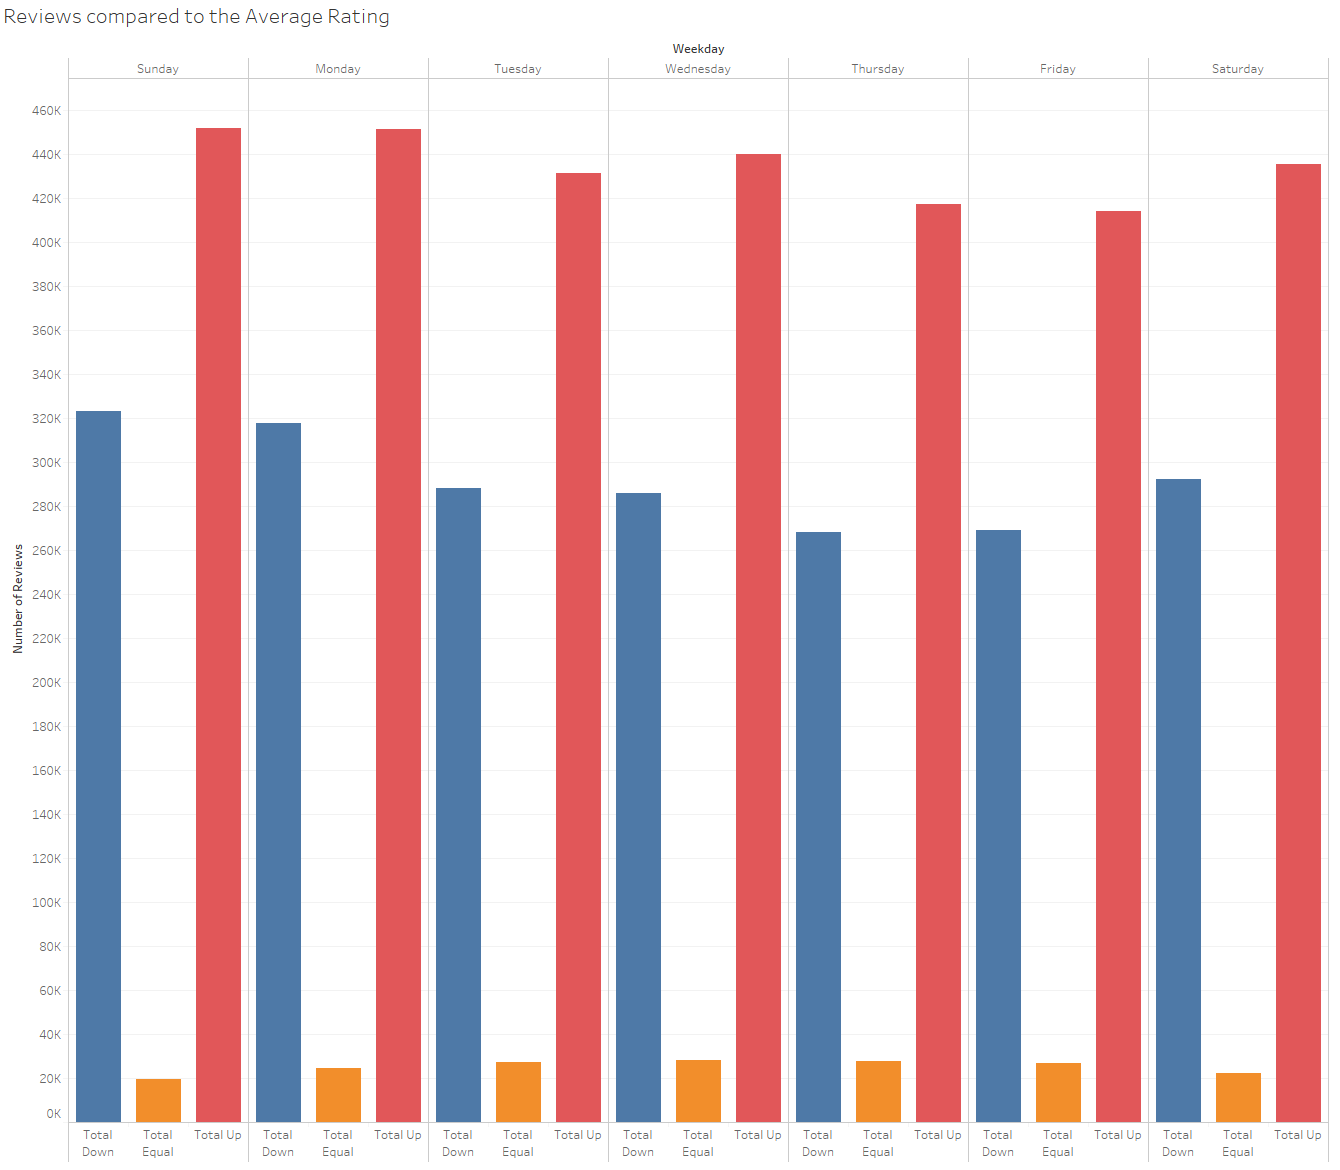

### Conclusion

In conclusion, there is no significant variance that shows users rating businesses differently depending on the day of the week. However, the results illustrate that overall there are more reviews that rate businesses higher than their average in comparison to lower than their average regardless of the day. Overall, this means that the Yelp business model is consistent and reliable because a weekday alone is not a significant influence on reivews.


---------------------------------------------------------------------------------------------------
# Question 2:  Does this vary by top-level category?

## Preparing and Structuring the Data: 

First we are going to create a dataframe that shows the top-level categories a business can be classified under. Yelp's available categories are structured like a tree. At the bottom of the tree are specific categories that reviewers can use to describe the business. These specific categories typically have a parent category which it can be classified under. This chain carries up the tree until it reaches the top-level category that contains no parent. Top-level categories are broad, such as "restaurant" or "shopping", due to the fact that they must be applicable to a wide range of businesses. All this being said, in order to determine whether our question varies by top-level category we must first know what these categories are called. Along with listing the top level categories, we will also list the title they classify under. The title is what will be used in our spark.sql to follow in order to determine what each review categorized the business under. 

In [39]:
top_level_categories = spark.sql("""
SELECT alias AS Category, Title
FROM categories
WHERE SIZE(parents) = 0
""")
top_level_categories.show(100, truncate=False)

+------------------+----------------------------+
|Category          |Title                       |
+------------------+----------------------------+
|active            |Active Life                 |
|arts              |Arts & Entertainment        |
|auto              |Automotive                  |
|beautysvc         |Beauty & Spas               |
|bicycles          |Bicycles                    |
|education         |Education                   |
|eventservices     |Event Planning & Services   |
|financialservices |Financial Services          |
|food              |Food                        |
|health            |Health & Medical            |
|homeservices      |Home Services               |
|hotelstravel      |Hotels & Travel             |
|localflavor       |Local Flavor                |
|localservices     |Local Services              |
|massmedia         |Mass Media                  |
|nightlife         |Nightlife                   |
|pets              |Pets                        |


Below is a pie chart found in Yelp's 10-K that gives a breakdown by industry (and top-level category) of local businesses that have recieved reviews. With this breakdown, it is shown that Shopping, Restaurants,and  Home & Local Services are the most reviewed and as a result would be best to use in order to determine whether our question varies by top-level category. We will also include Auto, Nightlife, and Travel & Hotel due to for a wider range of business models.

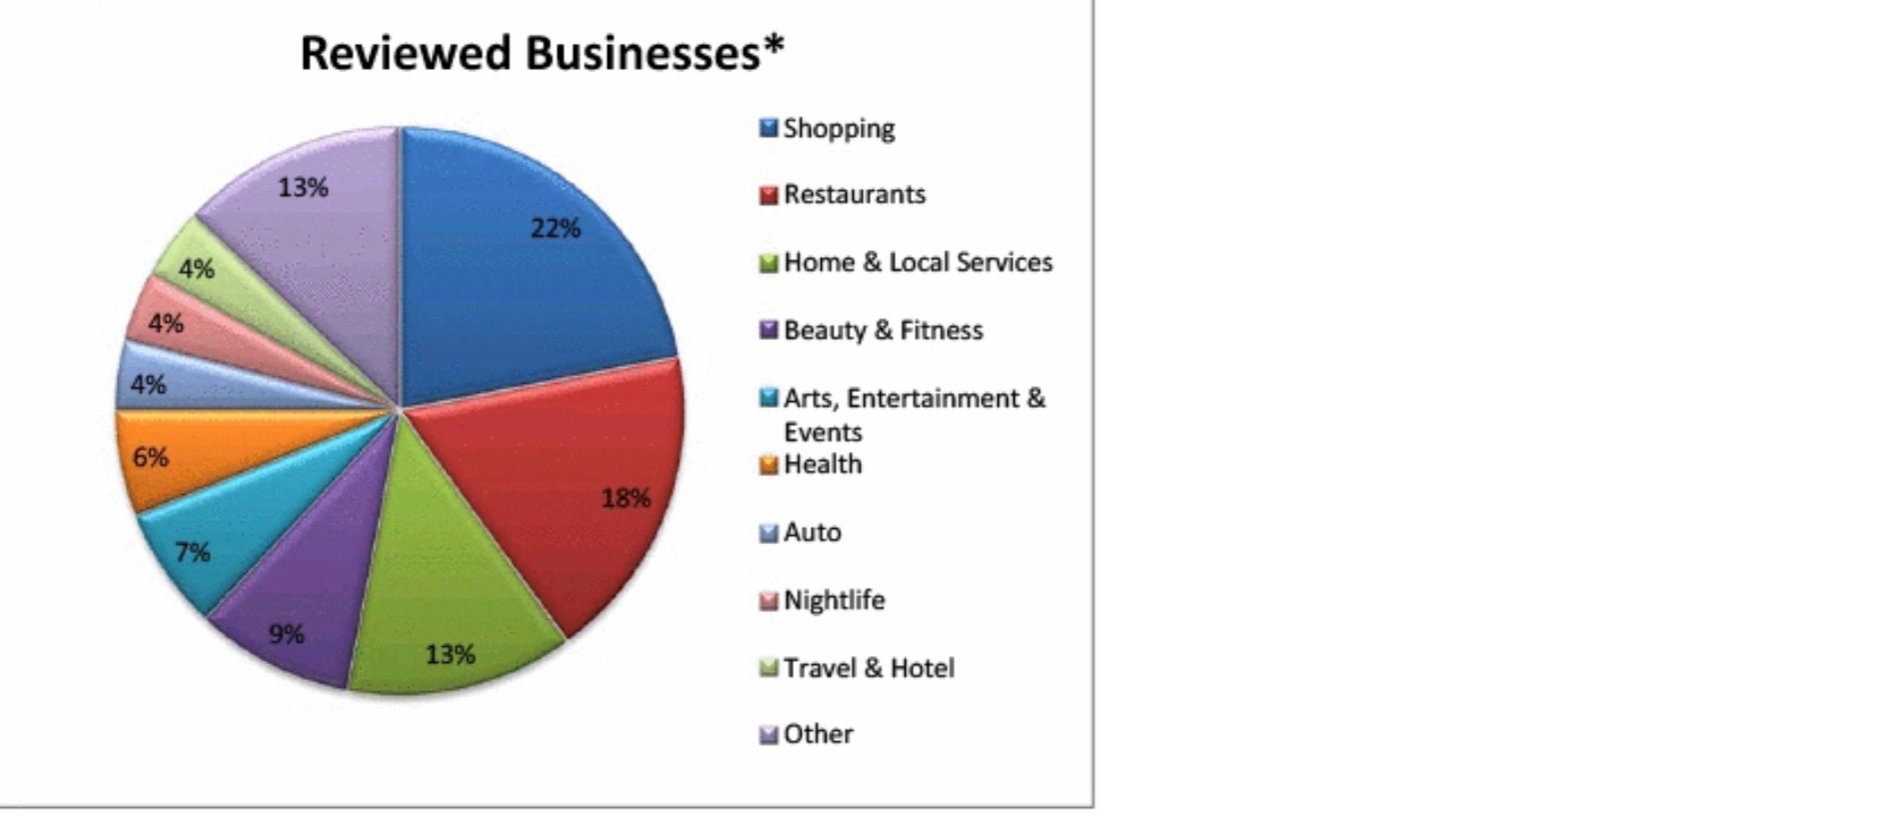 

Now that we know the available top-level categories to choose from we will now create our **"main_categories"** dataframe below. This dataframe will extract each business from the business.json file and show us what top-level category it falls under. However, with 22 top-level categories to choose from we will narrow our dataframe to only show if a business is categorized as "Shopping", "Restaurants", "Nightlife", "Health", "Hotels & Travel", "Auto", or "Home & Local Services". While home services and local services are listed as seperate top-level categories, they are grouped together in the Yelp 10-K so we will group them together as well for continuity. These eight categories were chosen because they are the most reviewed according to the pie chart above so they will offer us the most data. We also included less reviewed categories such as "Auto" or "Health" because they consist of significantly different business models from the more popular categories such as "Restaurants" or "Shopping". 

In [6]:
df_business.createOrReplaceTempView("business")

main_categories = spark.sql("""
SELECT business_id, state, 
     ARRAY_CONTAINS(categories, "Shopping") AS is_shopping,
     ARRAY_CONTAINS(categories, "Restaurants") AS is_restaurants,
     ARRAY_CONTAINS(categories, "Nightlife") AS is_nightlife,
     ARRAY_CONTAINS(categories, "Health & Medical") AS is_health,
     ARRAY_CONTAINS(categories, "Hotels & Travel") AS is_hotelstravel,
     ARRAY_CONTAINS(categories, "Automotive") AS is_auto,
     ARRAY_CONTAINS(categories, "Local Services") OR ARRAY_CONTAINS(categories, "Home Services") AS is_HomeLocalService
FROM business
""")

main_categories.show(20, truncate = False)



+----------------------+-----+-----------+--------------+------------+---------+---------------+-------+-------------------+
|business_id           |state|is_shopping|is_restaurants|is_nightlife|is_health|is_hotelstravel|is_auto|is_HomeLocalService|
+----------------------+-----+-----------+--------------+------------+---------+---------------+-------+-------------------+
|FYWN1wneV18bWNgQjJ2GNg|AZ   |false      |false         |false       |true     |false          |false  |false              |
|He-G7vWjzVUysIKrfNbPUQ|PA   |false      |false         |false       |false    |false          |false  |false              |
|KQPW8lFf1y5BT2MxiSZ3QA|AZ   |false      |false         |false       |false    |false          |false  |false              |
|8DShNS-LuFqpEWIp0HxijA|AZ   |true       |false         |false       |false    |false          |false  |false              |
|PfOCPjBrlQAnz__NXj9h_w|OH   |false      |true          |true        |false    |false          |false  |false              |


Next we will create the **combine** dataframe, to do this we will join the **test** dataframe which we made earlier in this project with the **main_categories** dataframe that we made above to help show if any trends lie within specific categories. This dataframe will be our largest dataframe offering the widet range of data to help answer our question. This being the case it will also be imported into tableau to create a visualization.  

In [13]:
test.createOrReplaceTempView("test")
main_categories.createOrReplaceTempView("main_categories")


combine = spark.sql("""
SELECT T.Business, T.Review, T.weekday, T.Rating, T.Average_Stars, T.Difference, T.Compare, M.state, M.is_shopping, M.is_restaurants, M.is_nightlife, M.is_health, M.is_hotelstravel, M.is_auto, M.is_HomeLocalService
FROM test AS T RIGHT JOIN main_categories AS M ON T.Business = M.business_id 
""")

combine.show(100, truncate = False)
print("when compare = 1 rating is less than the business' avg rating")
print("when compare = 2 rating is greater than the business' avg rating")
print("when compare = 3 rating is equal to the business' avg rating")

+----------------------+----------------------+---------+------+-------------+--------------------+-------+-----+-----------+--------------+------------+---------+---------------+-------+-------------------+
|Business              |Review                |weekday  |Rating|Average_Stars|Difference          |Compare|state|is_shopping|is_restaurants|is_nightlife|is_health|is_hotelstravel|is_auto|is_HomeLocalService|
+----------------------+----------------------+---------+------+-------------+--------------------+-------+-----+-----------+--------------+------------+---------+---------------+-------+-------------------+
|--9e1ONYQuAa-CB_Rrw7Tw|KEAHrqN-1DV0gmuNHM6Eww|Wednesday|5     |4.09         |0.9100000000000001  |2      |NV   |false      |true          |false       |false    |false          |false  |false              |
|--9e1ONYQuAa-CB_Rrw7Tw|6SgvNWJltnZhW7duJgZ42w|Thursday |5     |4.09         |0.9100000000000001  |2      |NV   |false      |true          |false       |false    |false

# RESULTS:

## Tableau Visualization Summary

Below is a visualization created from the **combine** dataframe above. Its purpose is to show the average difference between reviews and a business average for each day of the week split up by our 7 top-level categories. 

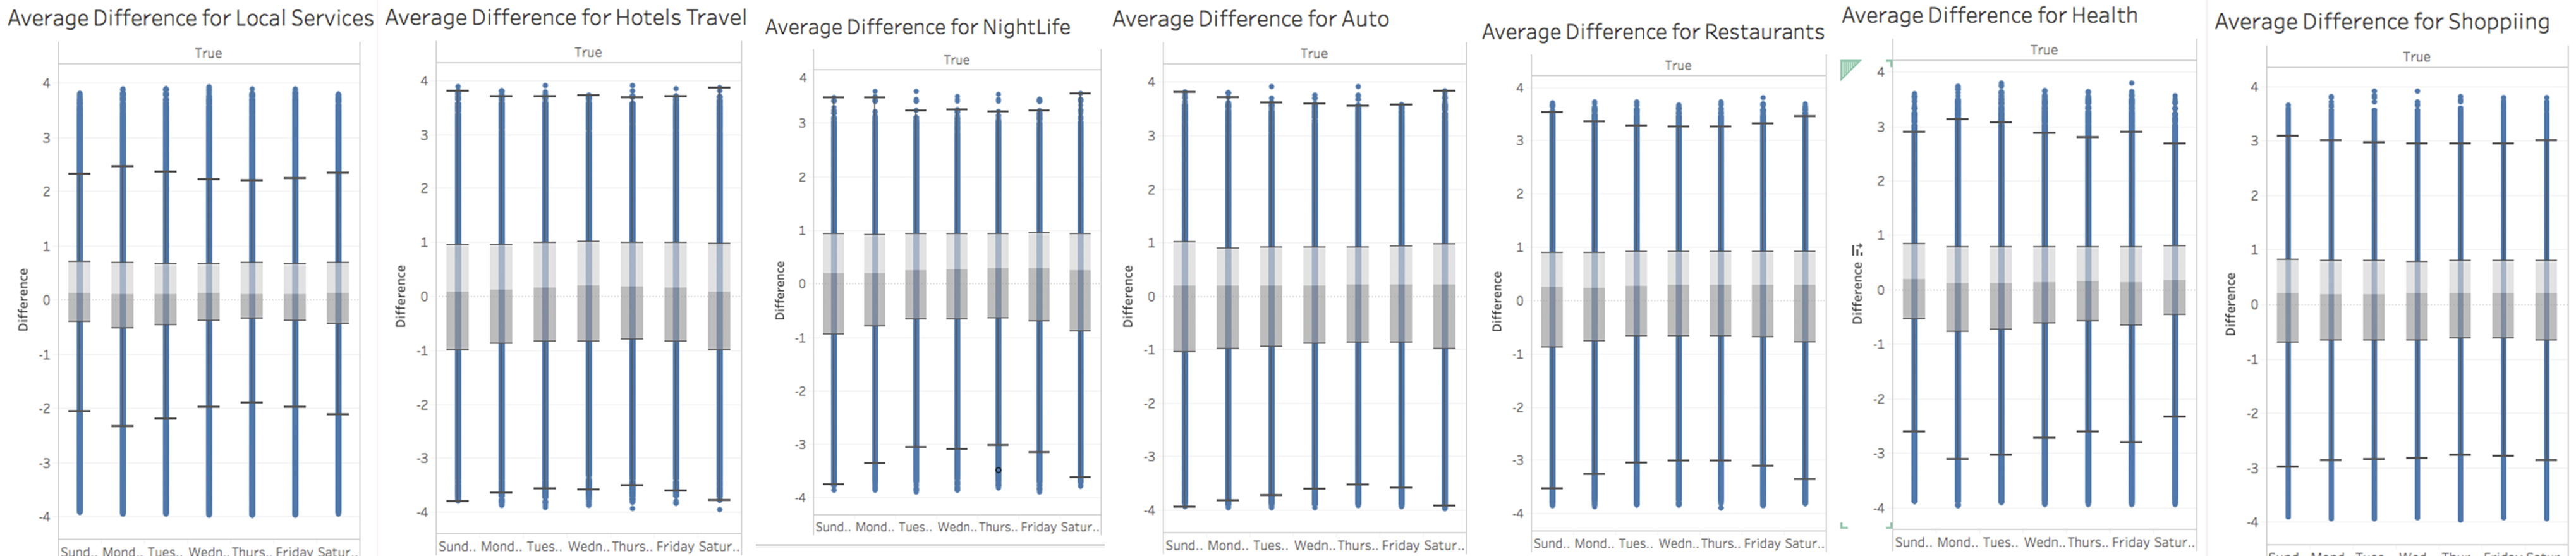

### Conclusion:

In conclusion, there is no significant variance within top-level categories that would suggest that weekdays influence reviews. This can be determined from the visualization above which indicates that while the range of average differences can vary, the median is consistantly within a small margin.  

----------------------------
# Question 3: Does this vary by city?

## Preparing and Structuring the Data: 

Now that we have looked into whether or not our question varies by top-level category, lets look into if it varies by city. While we say city, we actually mean metropolitan area because thats how Yelp's data is organized. Below we will create the **state_count** dataframe which simply counts the total number of reviews in each metropolitan area. This dataframe will be ordered by the total number of reviews in descending order so that we can see the areas with the most reviews. While we list the top 12 most reviewed, in order to maintain continuity we will only be using NV, AZ, ON, NC, OH, PA, QC, WI, IL, & SC because it is the areas that Yelp focuses their attention on. 

In [88]:
combine.createOrReplaceTempView("combine")

state_count = spark.sql("""
SELECT state, COUNT(review) AS Total_Reviews
FROM combine
GROUP BY state
ORDER BY Total_Reviews DESC
""")

state_count.show(12, truncate = False)

+-----+-------------+
|state|Total_Reviews|
+-----+-------------+
|NV   |1824442      |
|AZ   |1627792      |
|ON   |634366       |
|NC   |307665       |
|OH   |243768       |
|PA   |229850       |
|QC   |146372       |
|WI   |109751       |
|EDH  |47889        |
|IL   |36467        |
|BW   |35400        |
|SC   |10860        |
+-----+-------------+
only showing top 12 rows



Lastly, below is a dataframe that shows the average difference (difference = avg rating - rating) for each day of the week for businesses in each area. To make this, we will create an average difference dataframe for each day of the week and group the results by metro area. After this we will join each dataframe to create one consolidated dataframe called **state_days**. In state_days, when an avg_review is positive, that indicates that majority of reviews are higher than business averages. When avg_reviews are negative, that indicates that majority of reviews are lower than business averages. 

In [165]:
combine.createOrReplaceTempView("combine")

state_mon = spark.sql("""
SELECT state, ROUND(AVG(Difference), 5) AS MON_Avg_Dif
FROM combine
WHERE weekday = "Monday"
GROUP BY state
""")

state_tue = spark.sql("""
SELECT state, ROUND(AVG(Difference), 5) AS TUE_Avg_Dif
FROM combine
WHERE weekday = "Tuesday"
GROUP BY state
""")

state_wed = spark.sql("""
SELECT state, ROUND(AVG(Difference), 5) AS WED_Avg_Dif
FROM combine
WHERE weekday = "Wednesday"
GROUP BY state
""")

state_thur = spark.sql("""
SELECT state, ROUND(AVG(Difference), 5) AS THUR_Avg_Dif
FROM combine
WHERE weekday = "Thursday"
GROUP BY state
""")

state_fri = spark.sql("""
SELECT state, ROUND(AVG(Difference), 5) AS FRI_Avg_Dif
FROM combine
WHERE weekday = "Friday"
GROUP BY state
""")

state_sat = spark.sql("""
SELECT state, ROUND(AVG(Difference), 5) AS SAT_Avg_Dif
FROM combine
WHERE weekday = "Saturday"
GROUP BY state
""")

state_sun = spark.sql("""
SELECT state, ROUND(AVG(Difference), 5) AS SUN_Avg_Dif
FROM combine
WHERE weekday = "Sunday"
GROUP BY state
""")

state_mon.createOrReplaceTempView("state_mon")
state_tue.createOrReplaceTempView("state_tue")
state_wed.createOrReplaceTempView("state_wed")
state_thur.createOrReplaceTempView("state_thur")
state_fri.createOrReplaceTempView("state_fri")
state_sat.createOrReplaceTempView("state_sat")
state_sun.createOrReplaceTempView("state_sun")

state_days = spark.sql("""
SELECT M.*, T.TUE_Avg_Dif, W.WED_Avg_Dif, TH.THUR_Avg_Dif, F.FRI_Avg_Dif, SA.SAT_Avg_Dif, SU.SUN_Avg_Dif
FROM state_mon AS M INNER JOIN state_tue AS T ON M.State = T.State
    INNER JOIN state_wed AS W ON M.State = W.State
    INNER JOIN state_thur AS TH ON M.State = TH.State
    INNER JOIN state_fri AS F ON M.State = F.State
    INNER JOIN state_sat AS SA ON M.State = SA.State
    INNER JOIN state_sun AS SU ON M.State = SU.State
WHERE M.State = "AZ" OR
    M.State = "IL" OR
    M.State = "NC" OR
    M.State = "NV" OR
    M.State = "OH" OR
    M.State = "ON" OR
    M.State = "PA" OR
    M.State = "QC" OR
    M.State = "SC" OR
    M.State = "WI"
""")

state_days.show()
print("POSITIVE AVG_DIFF = Majority of ratings are HIGHER than business averages")
print("NEGATIVE AVG_DIFF = Majority of ratings are LOWER than business averages")

+-----+-----------+-----------+-----------+------------+-----------+-----------+-----------+
|state|MON_Avg_Dif|TUE_Avg_Dif|WED_Avg_Dif|THUR_Avg_Dif|FRI_Avg_Dif|SAT_Avg_Dif|SUN_Avg_Dif|
+-----+-----------+-----------+-----------+------------+-----------+-----------+-----------+
|   AZ|   -0.01708|    0.01072|    0.02688|     0.02777|    0.01735|   -0.01698|   -0.04485|
|   SC|    0.00839|    0.02486|   -0.00149|     0.06218|    0.01317|   -0.04559|   -0.04115|
|   QC|    0.00433|    0.01265|    0.01922|     0.02445|    0.00151|   -0.01502|   -0.03874|
|   NV|   -0.02597|    0.00965|    0.01989|     0.02513|    0.01765|    -0.0085|   -0.03494|
|   WI|   -0.00243|    0.01469|    0.02887|     0.02817|    0.01968|   -0.02581|    -0.0529|
|   NC|   -0.01309|    0.01321|    0.02099|      0.0426|    0.02155|   -0.01809|   -0.05558|
|   IL|   -0.05705|    0.02354|    0.04145|     0.03569|    0.04724|   -0.05338|   -0.03309|
|   OH|    -0.0082|     0.0255|    0.01993|     0.03257|    0.01003|  

# RESULTS:

## Tableau Visualizations Summary:

Below is a visualization created from the **combine** dataframe that shares a similar purpose to the **state_days** dataframe created above. Its purpose is to illustrate the average difference between reviews and businesses average rating for each day of the week, split up by our 9 metropolitan areas. 

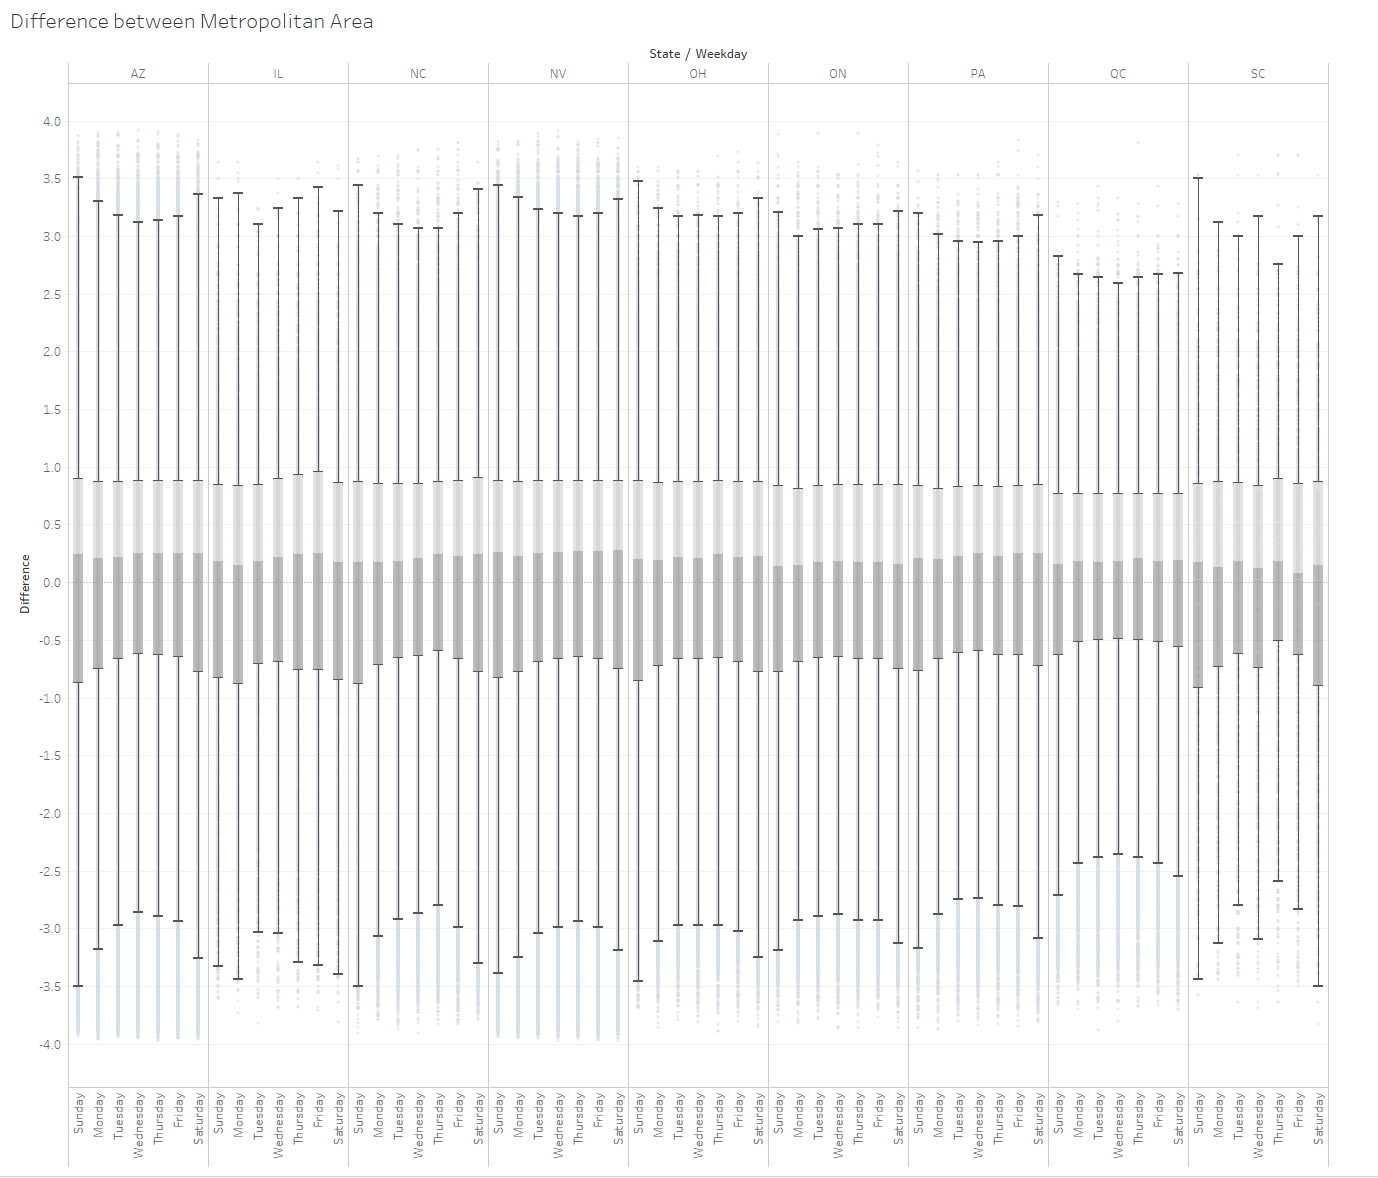

# Final Conclusion:

Similar to previous results, there is also no significant variance within metropolitan areas that would suggest that weekdays influence reviews. This can be determined from the visualization above which indicates that while the range of average differences can vary, the median is consistantly within a small margin.

Although a select few of businesses may vary in customer ratings throughout the week, the vast majority of businesses show no significant variance within each weekday. The fact that weekdays have little influence on how a user rates businesses means that this is good news for Yelps' business model. If a significant variance was identified, then yelp reviews would not be an accurate measure of the quality of that business. 

# Limitations

**1. Top-Level Categories overlapped**
>For example, a business can classify as a restaurant and nightlife

**2. Total number of reviews in “review.json” and “business.json” don't match**
>5,261,669 vs. 5,260,936

**3. Businesses with few reviews (1-3) could skew data**

**4. 23.3% of businesses in review.json had whole number avg ratings** 
>Reviews can equal their average rating
>3.4% of all reviews were neither up/down from the business average


Below is simply code neccessary for extracting the **combine** table as a CSV file that will used to create visualizations in tablaeu.

In [15]:
df_data_out=combine.repartition(1)
path_out = cos.url('combine10.tsv','teamhufflepuffyelpproject-donotdelete-pr-i8pakxtdmhzaka')
df_data_out.write.option("sep","\t").option("header","true").option("mode","overwrite").csv(path_out)